# HW2: kNN regression analysis Adult `hours-per-week`

---

**Citation**：
- [1] Harrington, P. (2012). *Machine Learning in Action*. Manning Publications.
- [2] https://github.com/frankstar007/kNN
- [3] https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
- [4] https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test

> ** 透過[1]來 KNN 邏輯，改寫為**迴歸版本**。


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Figure Chinese font settings
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False

## 1. 載入 Adult 資料集

In [3]:
def load_adult_data(train_path, test_path):
    columns = [
        'age', 'workclass', 'fnlwgt', 'education', 'education-num',
        'marital-status', 'occupation', 'relationship', 'race', 'sex',
        'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income_bracket'
    ]

    train_df = pd.read_csv(train_path, names=columns, na_values='?', skipinitialspace=True)
    test_df = pd.read_csv(test_path, names=columns, na_values='?', skiprows=1, skipinitialspace=True)

    # Delete missing values
    train_df = train_df.dropna().reset_index(drop=True)
    test_df = test_df.dropna().reset_index(drop=True)

    return train_df, test_df

# Load data and run
train_df, test_df = load_adult_data('data/adult.train.txt', 'data/adult.test.txt')
print(f"訓練集: {train_df.shape}")
print(f"測試集: {test_df.shape}")
train_df.head()

訓練集: (30162, 15)
測試集: (15060, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## 2. 資料前處理

In [8]:
def preprocess_data(train_df, test_df):
    y_train = train_df['hours-per-week'].values
    y_test = test_df['hours-per-week'].values
    X_train_raw = train_df.drop('hours-per-week', axis=1)
    X_test_raw = test_df.drop('hours-per-week', axis=1)

    # Categorical features
    categorical_cols = [
        'workclass', 'education', 'marital-status', 'occupation',
        'relationship', 'race', 'sex', 'native-country', 'income_bracket'
    ]
    encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        combined = pd.concat([X_train_raw[col], X_test_raw[col]])
        le.fit(combined.astype(str))
        X_train_raw[col] = le.transform(X_train_raw[col].astype(str))
        X_test_raw[col] = le.transform(X_test_raw[col].astype(str))
        encoders[col] = le

    # Normalize
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train_raw)
    X_test = scaler.transform(X_test_raw)

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = preprocess_data(train_df, test_df)
print(f"X_train shape: {X_train.shape}, y_train: {y_train.shape}")

X_train shape: (30162, 14), y_train: (30162,)


## 3. 自實現 kNN 迴歸器（改寫與參考自 `機器學習實戰p.19，書籍頁數：p.22`）
> 引用：[1] Harrington, P. (2012). *Machine Learning in Action*. Manning Publications.

In [5]:
class kNNRegressor:
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        self.X_train = np.array(X_train)
        self.y_train = np.array(y_train)
        return self

    def predict(self, X_test):
        # classify0() 邏輯
        X_test = np.array(X_test)
        predictions = []
        for i in range(X_test.shape[0]):
            # 步驟1: 計算歐氏距離
            distances = np.sqrt(np.sum((self.X_train - X_test[i]) ** 2, axis=1))
            # 步驟2: 排序取 k 最近鄰居
            nearest_indices = np.argsort(distances)[:self.k]
            # 步驟3: 迴歸預測 - 平均 y 值
            pred = np.mean(self.y_train[nearest_indices])
            predictions.append(pred)
        return np.array(predictions)

# 訓練與預測
knn = kNNRegressor(k=5)

print("開始訓練...")
start = time.time()
knn.fit(X_train, y_train)
train_time = time.time() - start

print("開始預測...")
start = time.time()
y_pred = knn.predict(X_test)
pred_time = time.time() - start
total_time = train_time + pred_time

開始訓練...
開始預測...


## 4. 績效評估

In [6]:
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("="*50)
print("kNN 迴歸結果 (k=5)")
print("="*50)
print(f"MAPE:  {mape:6.2f}%")
print(f"RMSE:  {rmse:6.2f}")
print(f"R²:    {r2:6.4f}")
print(f"訓練時間: {train_time:.4f} 秒")
print(f"預測時間: {pred_time:.4f} 秒")
print(f"總時間:   {total_time:.4f} 秒")
print("="*50)

kNN 迴歸結果 (k=5)
MAPE:   28.94%
RMSE:   11.28
R²:    0.1258
訓練時間: 0.0005 秒
預測時間: 38.4734 秒
總時間:   38.4739 秒


## 5. 視覺化比較（前200筆）

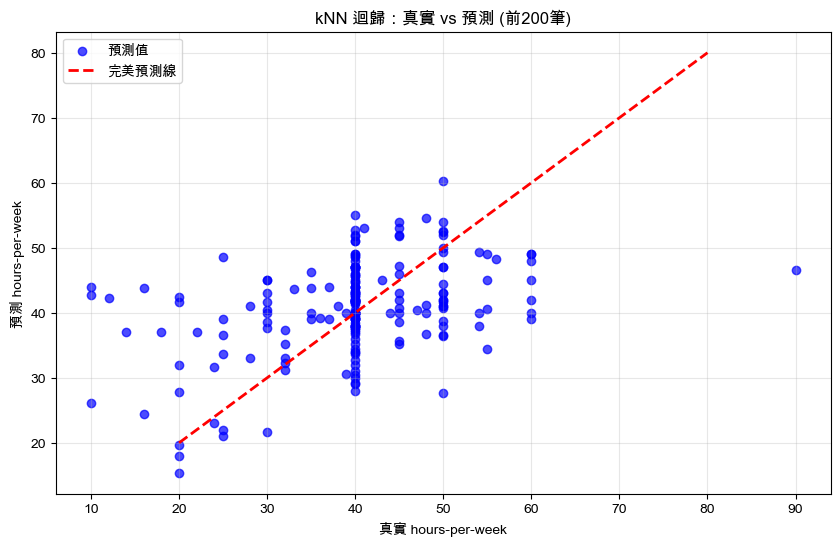

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test[:200], y_pred[:200], alpha=0.7, color='blue', label='預測值')
plt.plot([20, 80], [20, 80], 'r--', lw=2, label='完美預測線')
plt.xlabel('真實 hours-per-week')
plt.ylabel('預測 hours-per-week')
plt.title('kNN 迴歸：真實 vs 預測 (前200筆)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()